this quickstart file is a missile-target pursit built with the C4dynamics framework

In [12]:
# some setup

import numpy as np
from scipy.integrate import solve_ivp # odeint,
# import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

import sys, os
sys.path.append(os.getcwd() + '\\..')

import C4dynamics as c4d



<module 'C4dynamics' from 'd:\\gh_repo\\examples\\..\\C4dynamics\\__init__.py'>

In [5]:
# user inputs

rng0 = 1000
derr = 15 * np.pi / 180
theta0 = 15 * np.pi / 180
ts = .005
vT = 200
aT = 0
vM = 400
aMmax = 30
Ncmd = 3

In [6]:
# define objects 

tgt = c4d.datapoint(x = rng0)
msl = c4d.datapoint()

skr = c4d.seekers.radar(nstd = 0 * c4d.params.d2r)
pn  = c4d.path_planning.proportional_navigation(Ncmd, ts)

In [7]:
# initial conditions 

r = c4d.dist(tgt, msl)
lam = np.arcsin((tgt.y0 - msl.y0) / r)
tgt.theta = theta0
tgt.gamma = lam + tgt.theta

# def v_calc(obj):
#     return np.sqrt(obj.vx**2 + obj.vy**2 + obj.vz**2)

tgt.v = vT # v_calc(tgt)
msl.v = vM #  v_calc(msl)

del_correct = np.arcsin(tgt.v / msl.v * np.sin(tgt.gamma - lam))
msl.delta = del_correct + derr 

msl.gamma = lam + msl.delta
omega = (tgt.v * np.sin(tgt.theta) - msl.v * np.sin(msl.delta)) / r
msl.a = 0
tgt.a = aT

vc = -(tgt.v * np.cos(tgt.theta) - msl.v * np.cos(msl.delta))
msl.ac = Ncmd * msl.v * omega
if np.abs(msl.ac / 9.8) >= aMmax: msl.ac = np.sign(msl.ac) * aMmax * 9.8

msl.tau = 0.01

t = 0

# linear model
A = np.array([[msl.v - tgt.v, tgt.v, -msl.v], [0, 0, 0], [0, 0, 0]])
c = np.array([1, 0, 0])
lpf = c4d.filters.luenberger(A, c)
lpf.setest([200, 100, 100])
# xv = 

x = np.array([r, lam, omega, tgt.gamma, msl.gamma, msl.a, tgt.x, tgt.y, msl.x, msl.y])
msl.store(0)
tgt.store(0)

eps = np.zeros(2)
w_data = np.zeros((1, 3)) # time, omega true, omega calculated 

In [8]:
# system equations

def odx(t, x, tgt, msl): # function. (vs bound method)
    
    dx = np.zeros(x.shape)

    rho = x[0]
    # l   = x[1]
    w   = x[2]
    # gT  = x[3]
    # gM  = x[4]
    # aM  = x[5]

    dx[0] = tgt.v * np.cos(tgt.theta) - msl.v * np.cos(msl.delta)
    dx[1] = w

    x1_s = np.max([np.abs(rho), 1]) * np.sign(rho)
    dx[2] = -2 * (tgt.v * np.cos(tgt.theta) - msl.v * np.cos(msl.delta)) * w / x1_s + tgt.a * np.cos(tgt.theta) / x1_s - msl.a * np.cos(msl.delta) / x1_s

    if tgt.v != 0:
        dx[3] = tgt.a / tgt.v

    dx[4] = msl.a / msl.v
    dx[5] = -1 / msl.tau * msl.a + 1 / msl.tau * msl.ac 
    
    dx[6] = tgt.v * np.cos(tgt.gamma)
    dx[7] = tgt.v * np.sin(tgt.gamma)
    dx[8] = msl.v * np.cos(msl.gamma)
    dx[9] = msl.v * np.sin(msl.gamma)
    
    return dx
    


In [9]:
# run main loop 

while not pn.flyby:
    
    x = solve_ivp(odx, [t, t + ts], x, args = (tgt, msl)).y[:, -1]
    lam = x[1]
    w   = x[2]
    tgt.gamma = x[3]
    msl.gamma = x[4]
    msl.a = x[5]
    tgt.x = x[6]
    tgt.y = x[7]
    msl.x = x[8]
    msl.y = x[9]
    
    tgt.theta = tgt.gamma - lam    
    tgt.store(t)
    
    msl.delta = msl.gamma - msl.delta 
    
    # PN 
    #   measure los angle 
    #   find lambda dot
    #   filter noise
    eps = np.roll(eps, 1)
    eps[1] = skr.measure(lam)
    lambda_dot = np.diff(eps) / ts
    # xdot = lpf.Aest @ xv + 
    
    # apply command
    msl.ac = pn.PN(msl.v, lambda_dot)
    if np.abs(msl.ac / 9.8) >= aMmax: msl.ac = np.sign(msl.ac) * aMmax * 9.8
    
    # 
    msl.store(t)
    pn.set_flyby(x[0], r)
    r= x[0]
            
    w_data = np.vstack((w_data, np.array([t, w, lambda_dot]))).copy()
    t += ts

msl.curve('x')



c:\Users\Ziv Meri\.pyenv\pyenv-win\versions\3.7.4\lib\site-packages\ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


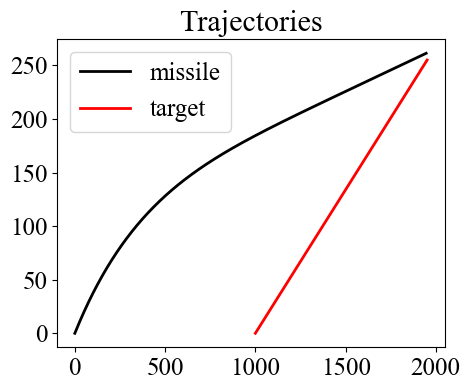

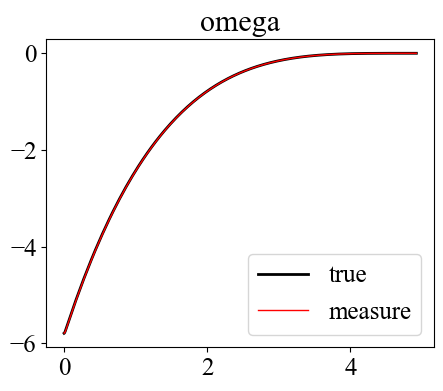

In [10]:
# plot trajectories 

xm = msl.data_x
ym = msl.data_y
xT = tgt.data_x
yT = tgt.data_y


plt.figure() 
plt.plot(xm, ym, 'k', linewidth = 2)
plt.plot(xT, yT, 'r', linewidth = 2)
plt.title('Trajectories')
ax = plt.gca()
ax.legend(['missile', 'target'])
# plt.show()

# omega 
plt.figure()
plt.plot(w_data[1:, 0], w_data[1:, 1] * c4d.params.r2d, 'k', linewidth = 2)
plt.plot(w_data[1:, 0], w_data[1:, 2] * c4d.params.r2d, 'r', linewidth = 1)
plt.title('omega')
ax = plt.gca()
ax.legend(['true', 'measure'])
# print(time.time() - tic)

# plt.show() 
#   plt.close()
#   plt.close('all')
